In [ ]:
!pip install --pre torch
!pip install xformers pytorch_lightning numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 51.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlink

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [6]:

import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch
import cv2
from io import BytesIO
from skimage import io
from math import e
from skimage.metrics import structural_similarity as ssim
from skimage.color import gray2rgb, gray2rgba
from tabulate import tabulate
# import lpips

from diffusers import LEditsPPPipelineStableDiffusion
from diffusers import StableDiffusionInstructPix2PixPipeline
from diffusers import DDIMScheduler, DDIMInverseScheduler, StableDiffusionDiffEditPipeline
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
from diffusers import StableUnCLIPImg2ImgPipeline
from diffusers import StableDiffusionXLInstructPix2PixPipeline
from transformers import CLIPTokenizer, CLIPTextModel
from diffusers.utils import load_image

from PIL import Image
import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")

# Data explanation


This tutorial is based on the paper Synthetic Scientific Image Generation with VAE, GAN, and Diffusion Model Architectures and is meant to run inference on diffusion-based models using 3 different datasets: the ROCKS dataset, the CMC dataset and the ROOTS dataset. We provide 3 samples for each of these datasets and the following prompts will be used as these models are multi-modal and take both images and guiding text to generate new data. 

**Prompts**:
- ROCKS: *microCT scan from a rock sample containing large sediment grains seperated by pores*
- ROOTS: *microscopy image of entangled
plant root in hydroponic system*
- CMC: *an X-ray image of a composite material with deformed circles*


In [3]:
# Add the path of the basefolder where the data is located and the generated samples will be save later in the notebook
basepath = "/content/drive/MyDrive/CAMERA Stable Diffusion"
tuto_datapath = os.path.join(basepath, 'data_tutorial')
raw_path = os.path.join(tuto_datapath, 'raw')

Number of input images available for ROOTS: 3


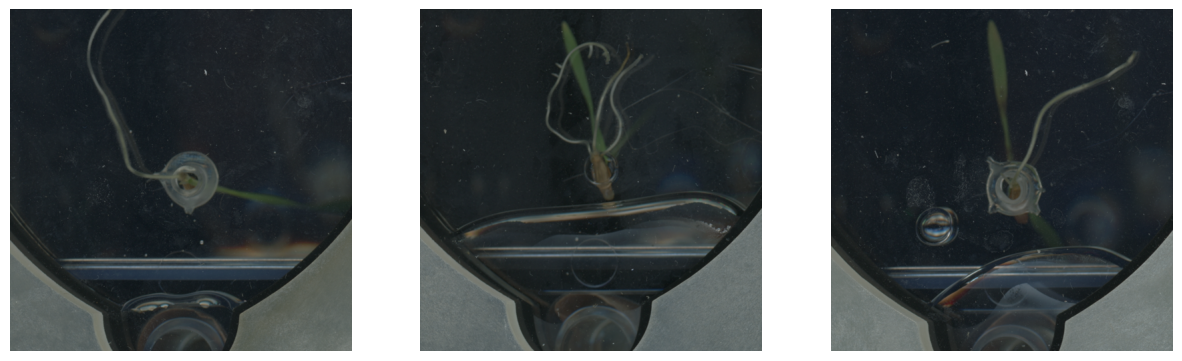

Number of input images available for CMC: 3


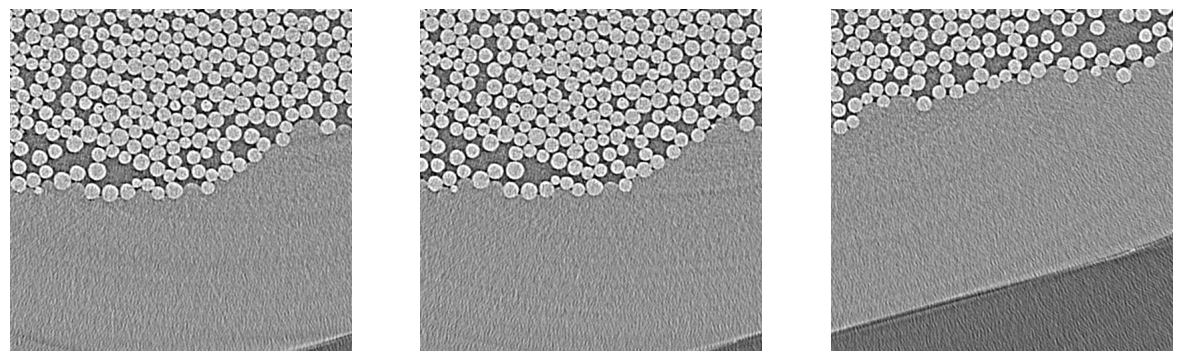

Number of input images available for ROCKS: 3


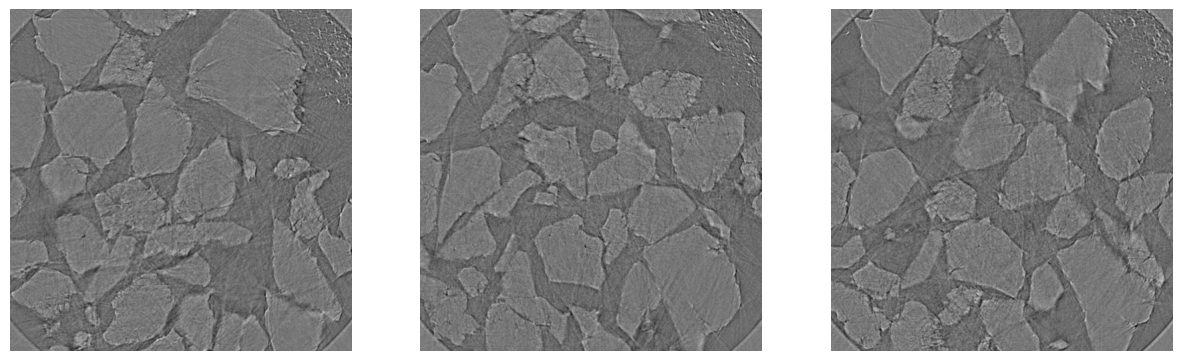

In [4]:
# First display all available input images for each type of data (among ROOTS, CMC and ROCKS)
for data in os.listdir(raw_path):
  lst_imgs = [e for e in os.listdir(os.path.join(raw_path, data)) if not e.startswith(".")]
  print("Number of input images available for {}: {}".format(data, len(lst_imgs)))
  fig, axs = plt.subplots(1, 3, figsize=(15, 5))
  for i in range(3):
    axs[i].imshow(io.imread(os.path.join(raw_path, data, lst_imgs[i])), cmap='gray')
    axs[i].axis('off')
  plt.show()

In [5]:
lst_prompts = ["an X-ray image of a composite material with deformed circles",  # CMC prompts
               "microCT scan from a rock sample containing large sediment grains seperated by pores", # ROCKS prompts
               "microscopy image of entangled plant root in hydroponic system"] # ROOTS prompts

datasets = ["CMC", "ROCKS", "ROOTS"]

# ControlNET

In [ ]:
model = "controlNET"
for data, prompt in zip(datasets, lst_prompts):

  # Get data and define save path
  data_path = os.path.join(basepath, "data_tutorial/raw/{}".format(data))
  lst_imgs_raw = [e for e in os.listdir(data_path) if not e.startswith(".")]
  print("Number of input images available: {}".format(len(lst_imgs_raw)))

  save_rootpath = os.path.join(basepath, "data_tutorial/generated/{}/{}".format(data, model))
  os.makedirs(save_rootpath, exist_ok=True)
  save_list = [e for e in os.listdir(save_rootpath) if not e.startswith(".")]

  # Infer on ControlNET
  controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
  pipe = StableDiffusionControlNetPipeline.from_pretrained(
      "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16)
  pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)
  pipe = pipe.to("cuda")

  generator = torch.manual_seed(0)
  for img_path in lst_imgs_raw:
    filename = img_path.split(".png")[0]

    print("Processing image {}".format(filename))
    raw_img = io.imread(os.path.join(data_path, img_path))
    rgb_img = gray2rgb(raw_img) # Convert to RGB image

    image = cv2.Canny(rgb_img, 100, 200)
    image = image[:, :, None]
    image = np.concatenate([image, image, image], axis=2)
    canny_image = Image.fromarray(image)

    lst_imgs = []

    n = 1 # Number of samples to generate for each input image. Default to 1
    for i in range (n):
      save_path = "controlNET_{}_{}_{}.png".format(data, filename, i)
      if not save_path in save_list:
        gen_image = pipe(prompt, num_inference_steps=30+i, generator=generator, image=canny_image).images[0]
        lst_imgs.append(gen_image)
        gen_image.save(os.path.join(save_rootpath, save_path))



# Stable unCLIP

In [ ]:
model = "stableunclip"
for data, prompt in zip(datasets, lst_prompts):

  # Get data and define save path
  data_path = os.path.join(basepath, "data_tutorial/raw/{}".format(data))
  lst_imgs_raw = [e for e in os.listdir(data_path) if not e.startswith(".")]
  print("Number of input images available: {}".format(len(lst_imgs_raw)))

  save_rootpath = os.path.join(basepath, "data_tutorial/generated/{}/{}".format(data, model))
  os.makedirs(save_rootpath, exist_ok=True)
  save_list = [e for e in os.listdir(save_rootpath) if not e.startswith(".")]

  # Infer on Stable unCLIP, and load Stability AI model and Open AI CLIP tokenizer
  clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
  clip_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to("cuda")

  tokenized_prompt_clip = clip_tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")
  prompt_embeds_clip = clip_text_encoder(tokenized_prompt_clip)[0]

  pipe = StableUnCLIPImg2ImgPipeline.from_pretrained(
      "stabilityai/stable-diffusion-2-1-unclip", torch_dtype=torch.float16, variation="fp16"
  )
  pipe = pipe.to("cuda")
  for img_path in lst_imgs_raw:
    filename = img_path.split(".png")[0]
    print("Processing image {}".format(filename))

    raw_img = io.imread(os.path.join(data_path, img_path))
    rgb_img = gray2rgb(raw_img) # Convert to RGB image
    image = Image.fromarray(rgb_img)

    n = 1
    for i in range (n):
      save_path = "stableunclip_{}_{}_{}.png".format(data, filename, i)
      if not save_path in save_list:
        gen_image = pipe(image, prompt).images[0]
        lst_imgs.append(gen_image)
        gen_image.save(os.path.join(save_rootpath, save_path))



# DiffEdit

In [ ]:
model = "diffedit"

# Modifying the previous prompts to instructive and guiding prompts for diffedit defined for each data type as ('mask_prompt', 'instruction_prompt')
lst_prompts_diffedit = [("large deformed circles", "small deformed circles"),
                        ("rock fragments and pores", "large rock fragments and small pores"),
                        ("entangled roots" "disentangled roots with leaves")]
for data, prompt in zip(datasets, lst_prompts):

  # Get data and define save path
  data_path = os.path.join(basepath, "data_tutorial/raw/{}".format(data))
  lst_imgs_raw = [e for e in os.listdir(data_path) if not e.startswith(".")]
  print("Number of input images available: {}".format(len(lst_imgs_raw)))

  save_rootpath = os.path.join(basepath, "data_tutorial/generated/{}/{}".format(data, model))
  os.makedirs(save_rootpath, exist_ok=True)
  save_list = [e for e in os.listdir(save_rootpath) if not e.startswith(".")]


  # Load DiffEdit
  mask_prompt = prompt[0]
  prompt = prompt[1]

  pipeline = StableDiffusionDiffEditPipeline.from_pretrained(
        "stabilityai/stable-diffusion-2-1", torch_dtype=torch.float16)

  pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
  pipeline.inverse_scheduler = DDIMInverseScheduler.from_config(pipeline.scheduler.config)
  pipeline = pipeline.to("cuda")

  lst_imgs_diffedit = []
  lst_masks_diffedit = []
  n = 1 # Number of samples to generate for each input image.

  for img_path in lst_imgs_raw:
    filename = img_path.split(".png")[0]
    print("Processing image {}".format(filename))

    raw_img = io.imread(os.path.join(data_path, img_path))
    rgb_img = gray2rgb(raw_img) # Convert to RGB image
    image = Image.fromarray(rgb_img)

    for i in range (n):
      save_path = "diffedit_{}_{}_{}.png".format(data, filename, i)

      if not save_path in save_list:
        mask_image = pipeline.generate_mask(image=image, source_prompt=prompt, target_prompt=mask_prompt)
        image_latents = pipeline.invert(image=image, prompt=mask_prompt).latents
        gen_image = pipeline(prompt=prompt, mask_image=mask_image, image_latents=image_latents).images[0]
        lst_imgs_diffedit.append(gen_image)
        lst_masks_diffedit.append(mask_image)
        gen_image.save(os.path.join(save_rootpath, save_path))


# LEDITS++


In [ ]:
model = "stableunclip"
for data, prompt in zip(datasets, lst_prompts):

  # Get data and define save path
  data_path = os.path.join(basepath, "data_tutorial/raw/{}".format(data))
  lst_imgs_raw = [e for e in os.listdir(data_path) if not e.startswith(".")]
  print("Number of input images available: {}".format(len(lst_imgs_raw)))

  save_rootpath = os.path.join(basepath, "data_tutorial/generated/{}/{}".format(data, model))
  os.makedirs(save_rootpath, exist_ok=True)
  save_list = [e for e in os.listdir(save_rootpath) if not e.startswith(".")]

  # Load LEDITS++ pipeline
  pipe = LEditsPPPipelineStableDiffusion.from_pretrained(
      "runwayml/stable-diffusion-v1-5", variant="fp16", torch_dtype=torch.float16)
  pipe.enable_vae_tiling()
  pipe = pipe.to("cuda")

  n = 1 # Number of samples to generate for each input. Default to 1.
  for img_path in lst_imgs_raw:
    filename = img_path.split(".png")[0]
    print("Processing image {}".format(filename))

    raw_img = io.imread(os.path.join(data_path, img_path))
    rgb_img = gray2rgb(raw_img) # Convert to RGB image
    image = Image.fromarray(rgb_img)

    _ = pipe.invert(image=image, num_inversion_steps=50, skip=0.1)

    j = 0
    for i in range (n):
      save_path = "ledits_{}_{}_{}.png".format(data, filename, i)
      edited_image = pipe(editing_prompt=[prompt], edit_guidance_scale=10.0 + j, edit_threshold=0.75).images[0]
      j += 10
      edited_image.save(os.path.join(save_rootpath, save_path))


# InstructPix2Pix

In [ ]:
model = "instructpix2pix"
lst_prompts_instructpix2pix = ["make circles larger", "large rock fragments and pores", "growing entangled plant roots"]

for data, prompt in zip(datasets, lst_prompts_instructpix2pix):

  # Get data and define save path
  data_path = os.path.join(basepath, "data_tutorial/raw/{}".format(data))
  lst_imgs_raw = [e for e in os.listdir(data_path) if not e.startswith(".")]
  print("Number of input images available: {}".format(len(lst_imgs_raw)))

  save_rootpath = os.path.join(basepath, "data_tutorial/generated/{}/{}".format(data, model))
  os.makedirs(save_rootpath, exist_ok=True)
  save_list = [e for e in os.listdir(save_rootpath) if not e.startswith(".")]

  # Load InstructPix2Pix
  resolution = 512
  pipe = StableDiffusionXLInstructPix2PixPipeline.from_pretrained(
      "diffusers/sdxl-instructpix2pix-768", torch_dtype=torch.float16
  ).to("cuda")

  n = 1 # Number of samples to generate for each input image
  for img_path in tqdm(lst_imgs_raw):
    filename = img_path.split(".png")[0]
    print("Processing image {}".format(filename))

    raw_img = io.imread(os.path.join(data_path, img_path))
    rgb_img = gray2rgb(raw_img)
    image = Image.fromarray(rgb_img)

    j = 0
    for i in range(n):
      save_path = "instructpix2pix_{}_{}_{}.png".format(data, filename, i)
      if not save_path in save_list:
        edited_image_instructpix2pix = pipe(
          prompt=prompt,
          image=image,
          height=resolution,
          width=resolution,
          guidance_scale=3.0+j,
          image_guidance_scale=1.5+j,
          num_inference_steps=30,
          ).images[0]
        j += 1
        edited_image_instructpix2pix.save(os.path.join(save_rootpath, save_path))
